# Distributed data parallel MaskRCNN training with TensorFlow 2 and SageMaker

This notebook example shows how to use smdistributed.dataparallel with TensorFlow (version 2.4.1) on Amazon SageMaker to train a MaskRCNN model on COCO 2017 dataset using Amazon FSx for Lustre file-system as data source. Basically this notebook is using next original example code (Original source : https://github.com/aws/amazon-sagemaker-examples/blob/master/training/distributed_training/tensorflow/data_parallel/maskrcnn/tensorflow2_smdataparallel_maskrcnn_demo.ipynb) but some configuration and analytics codes were added for the workshop.


**NOTE :** This code is using SageMaker bring your own container algorithm concpet. For more information of this concept you can refer to this link : https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html


---
## STEP 1. Preparing dataset, pretrained model, and training script

For more efficient workshop, dataset and pretrainded model, algorithm iamge, etc. are ready to be run.  

_If you want to configure these resources manually, you can use CloudFormation template([`TF_DP_CFN.yaml`](TF_DP_CFN.yaml)) included._

Finalize the perepartion by nstall additional dependencies and check the resources.

In [1]:
!python3 -m pip install --upgrade sagemaker
!pip install pycocotools
!pip install smdebug

  Using cached sagemaker-2.52.2.post0-py2.py3-none-any.whl
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.45.0
    Uninstalling sagemaker-2.45.0:
      Successfully uninstalled sagemaker-2.45.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python3 -m pip install --upgrade pip' command.
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp36-cp36m-linux_x86_64.whl size=103251 sha256=ba1f67c79ac916eb4f8ffbad7f56fc9caa2028cf3d7fb119b29770b80cd16b3d
  Stored in directory: /home/ec2-user/.cache/pip/wheels/d8/c2/ba/8f5306f921c2e79ad7b09effdfed6bd966cfcf8c6fe55422d6
Successfully built pycocotools
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 269 kB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 2.6 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-u

### Checking dataset in s3

In your SageMaker default bucket, you can find coco-datset(https://cocodataset.org/) as tfrecord format. 

Files in your s3 will look like below:

```(bash)
# training images
<PATH>/train/train-00000-of-00256.tfrecord
             train-00001-of-00256.tfrecord
             train-00002-of-00256.tfrecord 
             ...
# pretrained model
<PATH>/model/resnet/resnet-nhwc-2018-02-07/checkpoint
                                           model.ckpt-112603.data-000...
                                           model.ckpt-112603.index
                                           model.ckpt-112603.meta
```

Here, `<PATH>` will be next format in S3
- s3://sagemaker-{region}-{your-account-id}/coco_dataset/

And it will be synched to `/opt/ml/input/data/train/` folder inside the SageMaker Tensorflow container later.

Let's check some of them with below code.

In [2]:
import sagemaker
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

!aws s3 ls s3://{bucket}/coco_dataset/train/

2021-08-12 14:59:14   75763948 train-00000-of-00256.tfrecord
2021-08-12 14:59:15   76083838 train-00001-of-00256.tfrecord
2021-08-12 14:59:15   76832268 train-00002-of-00256.tfrecord
2021-08-12 14:59:15   77138520 train-00003-of-00256.tfrecord
2021-08-12 14:59:15   75993126 train-00004-of-00256.tfrecord

[Errno 32] Broken pipe
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='UTF-8'>
BrokenPipeError: [Errno 32] Broken pipe


### Checking FSx for Lustre 

Distributed training usually requires faster acess to training dataset. High-speed storage like **FSx for Lustre** is the best storage option for this requirement.

For the workshop, you already have FSx Lustre cluster connected to above s3 coco-dataset storage.  
Open [FSx for Lustre console](https://console.aws.amazon.com/fsx/) and check click the filesystem name

You can see the screen like below:

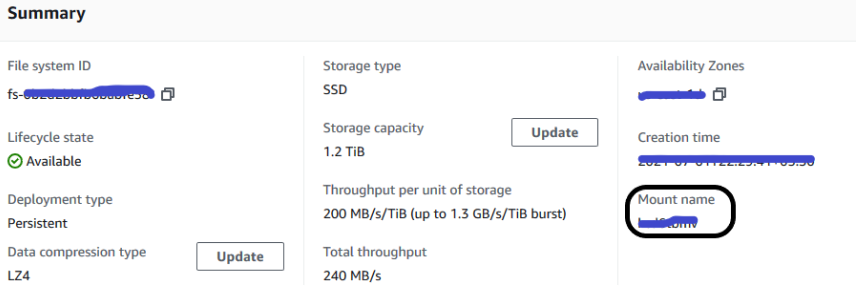

### TO DO: Remember the mount name and File system ID by updating nex cell.

In [3]:
fsx_mount_name = "5a335bmv"     # will look like "cs3oxbmv"
file_system_id = "fs-036be24766d6cf23f" # will look like "fs-0657fe7d92a4c2345"

assert (fsx_mount_name !="<<your Mount name>>"), "Please update the mount name with yours"
assert (file_system_id !="<<your File system ID>>"), "Please update the File system ID with yours"


In [4]:
import boto3
session = boto3.session.Session()
region = session.region_name

file_system_dns_name = "{}.fsx.{}.amazonaws.com".format(file_system_id, region)
print(file_system_dns_name)

fs-036be24766d6cf23f.fsx.us-west-2.amazonaws.com


Below command will mount FSx filesystem to this notebook as a test and you can see the filesystm connected to your S3 stroage with below cell command. 

(Actually we do not need to access thsi filesystem from this notebook since we will route training job to SageMaker environment. However, in your development project, you probabliy need to check the filesystem. For more information of accessing FSx Lustre filesystem, you can refer to this link: https://docs.aws.amazon.com/fsx/latest/LustreGuide/accessing-fs.html)


In [5]:
# !sudo mkdir -p /fsx
# !sudo mount -t lustre -o noatime,flock {file_system_dns_name}@tcp:/{fsx_mount_name} /fsx
# !ls -al /fsx/coco_dataset/

### TO DO : Update "subnets", "security_group_ids" from the outputs of the CloudFormation as below

Similar to the file system information, VPC information for accessing FSx will be used when training later. 

Open the [CloudFormation console](https://console.aws.amazon.com/cloudformation) and click the stack. And move to Outputs tab and check the output of CloudFormation and update the two values. (subnet and security group)

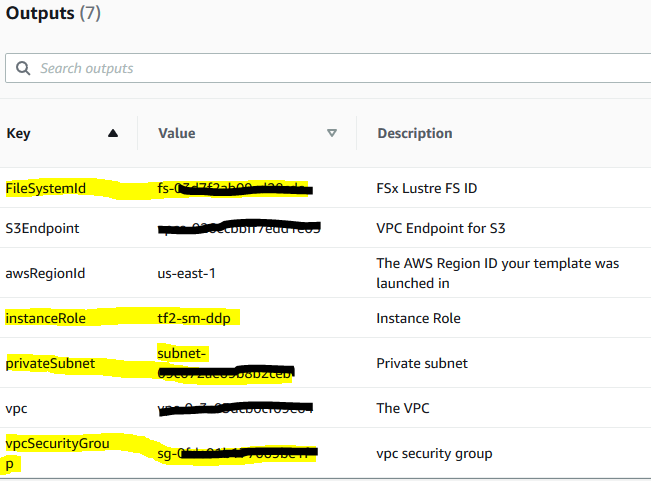

In [6]:
subnet_id = "subnet-0f976083f75e4a55b"                 # will look like "subnet-0c961835de0f9a801"
security_group_id = "sg-08d7600f1d79355c5" # will look like "sg-0999ec95f8003d3e1"

assert (subnet_id != "<<your subnet>>" ), "Please update subnet id with yours"
assert (security_group_id != "<<your security group>>"), "Please update security group id with yours"



### Preparing SageMaker Training Image

SageMaker provides the latest [Amazon Deep Learning Container Images (DLC)](https://github.com/aws/deep-learning-containers/blob/master/available_images.md) TensorFlow training image. In this step, we use it as a base image and install additional dependencies required for training MaskRCNN model.


**Build and Push Docker Image to ECR**

For more efficient workshop, we pre-configured the training docker iamge in your notebook.

In [7]:
!docker images

REPOSITORY          TAG                 IMAGE ID            CREATED             SIZE


Use this docker iamge and push it to your ECR with below command. **(It will take around 5~10 minutes.)**

In [8]:
%%sh

REGION=$(aws configure get region)
IMAGE_NAME="tf2-mask-rcnn-ddp2"  
TAG="latest"  

chmod +x build_and_push.sh; bash build_and_push.sh $REGION $IMAGE_NAME $TAG

Login Succeeded

Step 1/5 : ARG region
Step 2/5 : FROM 763104351884.dkr.ecr.us-west-2.amazonaws.com/tensorflow-training:2.4.1-gpu-py37-cu110-ubuntu18.04
2.4.1-gpu-py37-cu110-ubuntu18.04: Pulling from tensorflow-training
171857c49d0f: Pulling fs layer
419640447d26: Pulling fs layer
61e52f862619: Pulling fs layer
2a93278deddf: Pulling fs layer
c9f080049843: Pulling fs layer
8189556b2329: Pulling fs layer
48201db7094c: Pulling fs layer
52c012740c87: Pulling fs layer
4ea8c97a046a: Pulling fs layer
cf567978f146: Pulling fs layer
6debf6d5a580: Pulling fs layer
31a291f7c7a3: Pulling fs layer
79b923967117: Pulling fs layer
87a6c868b245: Pulling fs layer
51c2b0566974: Pulling fs layer
0670b55c8fe8: Pulling fs layer
d8db51f37e08: Pulling fs layer
54b7c14aac6f: Pulling fs layer
8a648cfd9dd8: Pulling fs layer
9ecba1440a31: Pulling fs layer
44fc43b56dd8: Pulling fs layer
e061109d2aaa: Pulling fs layer
093d7bbe34cb: Pulling fs layer
c37c334e9365: Pulling fs layer
3b23c5a12349: Pulling fs layer
278bb

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



**NOTE :** If you want to configure this image manually, you can build it with this [Dockerfile](Dockerfile) included.

In [9]:
# !pygmentize ./Dockerfile

In [10]:
# !pygmentize ./build_and_push.sh

### Preparing training script

In the Github repository https://github.com/HerringForks/DeepLearningExamples.git we have made `smdistributed.dataparallel` TensorFlow  MaskRCNN training script available for your use. We will be installing the same on the training image.

In [11]:
!rm -rf DeepLearningExamples
!git clone --recursive https://github.com/HerringForks/DeepLearningExamples.git


Cloning into 'DeepLearningExamples'...
remote: Enumerating objects: 23258, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 23258 (delta 85), reused 127 (delta 59), pack-reused 23090
Receiving objects: 100% (23258/23258), 57.85 MiB | 29.54 MiB/s, done.
Resolving deltas: 100% (17904/17904), done.


---

## STEP 2. Amazon SageMaker Estimator using data parallel

Now we have all resource to run our experiment. Let's start training job.

### Amazon SageMaker Initialization

In [12]:
from sagemaker import get_execution_role
import boto3

role = get_execution_role()   # provide a pre-existing role ARN as an alternative to creating a new role
print(f"SageMaker Execution Role:{role}")

client = boto3.client("sts")
account = client.get_caller_identity()["Account"]
print(f"AWS account:{account}")



SageMaker Execution Role:arn:aws:iam::072851894905:role/tf2-sm-ddp2
AWS account:072851894905


To verify that the role above has required permissions:

1. Go to the IAM console: https://console.aws.amazon.com/iam/home.
2. Select **Roles**.
3. Enter the role name in the search box to search for that role. 
4. Select the role.
5. Use the **Permissions** tab to verify this role has required permissions attached.

### Defining SageMaker TensorFlow Estimator 



In the following code block, you can update the estimator function to use a different instance type, instance count, and distrubtion strategy. You're also passing in the training script you reviewed in the previous cell.

**Instance types**

`smdistributed.dataparallel` supports model training on SageMaker with the following instance types only. For best performance, it is recommended you use an instance type that supports Amazon Elastic Fabric Adapter (ml.p3dn.24xlarge and ml.p4d.24xlarge).

1. ml.p3.16xlarge
1. ml.p3dn.24xlarge [Recommended]
1. ml.p4d.24xlarge [Recommended]

**Instance count**

To get the best performance and the most out of `smdistributed.dataparallel`, you should use at least 2 instances, but you can also use 1 for testing this example.


In [13]:
image = "tf2-mask-rcnn-ddp2"  
tag = "latest"
instance_type = "ml.p3.16xlarge"   # Other supported instance type: ml.p3.16xlarge, ml.p4d.24xlarge ml.p3dn.24xlarge
instance_count = 2                 # You can use 2, 4, 8 etc.
docker_image = f"{account}.dkr.ecr.{region}.amazonaws.com/{image}:{tag}"  # YOUR_ECR_IMAGE_BUILT_WITH_ABOVE_DOCKER_FILE

subnets = [subnet_id]                      # Should be same as Subnet used for FSx. Example: subnet-0f9XXXX
security_group_ids = [security_group_id]   # Should be same as Security group used for FSx. sg-03ZZZZZZ

SM_DATA_ROOT = "/opt/ml/input/data/train"

hyperparameters = {
    "mode": "train",
    "checkpoint": "/".join([SM_DATA_ROOT, "model/resnet/resnet-nhwc-2018-02-07/model.ckpt-112603"]),
    "eval_samples": 5000,
    "init_learning_rate": 0.04,
    "learning_rate_steps": "3750,5000",
    "model_dir": "/opt/ml/code/checkpoints/tensorflow_mask_rcnn",
    "num_steps_per_eval": 462,
    "total_steps": 500,
    "train_batch_size": 4,
    "eval_batch_size": 8,
    "training_file_pattern": "/".join([SM_DATA_ROOT, "train"]),
    "validation_file_pattern": "/".join([SM_DATA_ROOT, "val"]),
    "val_json_file": "/".join([SM_DATA_ROOT, "annotations/instances_val2017.json"]),
    "amp": "",
    "use_batched_nms": "",
    "xla": "",
    "nouse_custom_box_proposals_op": "",
    "seed": 987,
}

**Set SageMaker Debugger Profiler**

You can monitor GPU resource consumption with SageMaker Debugger. Set a SageMaker ProfilerConfig to monitor training instace every 500 miliseconds with default configuration.


In [14]:
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile()
)

**Distribution strategy**

Note that to use DDP mode, you update the the `distribution` strategy, and set it to use `smdistributed dataparallel`.


In [15]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    entry_point="DeepLearningExamples/TensorFlow2/Segmentation/MaskRCNN/mask_rcnn_sm.py",
    role=role,
    image_uri=docker_image,
    source_dir=".",
    framework_version="2.4.1",
    py_version="py37",
    instance_count=instance_count,
    instance_type=instance_type,
    sagemaker_session=sagemaker_session,
    subnets=subnets,
    hyperparameters=hyperparameters,
    security_group_ids=security_group_ids,
    debugger_hook_config=False,
    # Training using smdistributed.dataparallel Distributed Training Framework
    distribution={"smdistributed": {"dataparallel": {"enabled": True, "custom_mpi_options": "-verbose -x NCCL_DEBUG=VERSION"}}},
    profiler_config=profiler_config,
)

### Run training job

Configure FSX input dataset and submit training job. **(Training will take 20~22 minutes.)**

In [16]:
# Configure FSx Input for your SageMaker Training job

from sagemaker.inputs import FileSystemInput
file_system_directory_path = "/"+fsx_mount_name+"/coco_dataset"   # NOTE: '/fsx/' will be the root mount path. Example: '/fsx/mask_rcnn/PyTorch' l4po7bmv
file_system_access_mode = "ro"
file_system_type = "FSxLustre"
train_fs = FileSystemInput(
    file_system_id=file_system_id,
    file_system_type=file_system_type,
    directory_path=file_system_directory_path,
    file_system_access_mode=file_system_access_mode,
)
data_channels = {"train": train_fs}

In [ ]:
%%time
# Submit SageMaker training job
estimator.fit(inputs=data_channels)

2021-08-12 16:09:09 Starting - Starting the training job...
2021-08-12 16:09:12 Starting - Launching requested ML instancesProfilerReport-1628784526: InProgress
.........
2021-08-12 16:11:06 Starting - Preparing the instances for training............
2021-08-12 16:13:09 Downloading - Downloading input data
2021-08-12 16:13:09 Training - Downloading the training image...........................2021-08-12 16:17:28.971450: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-08-12 16:17:28.976872: I tensorflow/core/profiler/internal/smprofiler_config_reader.cc:123] PID of the process that is writing to the timeline : 1
2021-08-12 16:17:28.977357: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:121] SageMaker Profiler Timeline Writer read the following config parameters :
2021-08-12 16:17:28.977371: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:122] Base Folder : /opt/ml/output/profiler
2021-08-12 16:17:28.977376:

---
## STEP 3. Training script review

Check the training script. (source from: https://github.com/HerringForks/DeepLearningExamples)

From the entrypoint script `DeepLearningExamples/TensorFlow2/Segmentation/MaskRCNN/mask_rcnn_sm.py` that you defined above, you can find training script to use SageMaker data parallel. This sample code composed of:
- `mask_rcnn_sm.py` calls `mask_rcnn_main.py` with hyperparameters
- `mask_rcnn_main.py` uses `distributed_executer.EstimatorExecuter` object to run training job in parallel. (Check the file with below cell command.)

For more information regarding training script using Sagemaker data parallel. You can refer to this resource https://docs.aws.amazon.com/sagemaker/latest/dg/data-parallel.html



In [ ]:
# !pygmentize DeepLearningExamples/TensorFlow2/Segmentation/MaskRCNN/mask_rcnn/distributed_executer.py

---
## STEP 4. Monitor training instances with SageMaker Debugger profiler

SageMaker Debugger profiler provide resource monitoring while training is running. Below code will check the profiling data is ready to track. 

In [ ]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

In [ ]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

In [ ]:
# Get the metrics reader and refresh it
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()


## Plotting Metrics

Wile running training job, training job will create resource profile and Debugger job will collect this metric. You can monitor whether the resources are utilized properly for our training job with below visualization tools. You can continue to monitor it in the middle and later

### System metrics histogram

In [ ]:
from smdebug.profiler.analysis.notebook_utils.metrics_histogram import MetricsHistogram

metrics_histogram = MetricsHistogram(system_metrics_reader)
metrics_histogram.plot(
    starttime=0, 
    endtime=system_metrics_reader.get_timestamp_of_latest_available_file(), 
    select_dimensions=["CPU", "I/O"],
    select_events=["total"]
)

In [ ]:
metrics_histogram = MetricsHistogram(system_metrics_reader)
metrics_histogram.plot(
    starttime=0, 
    endtime=system_metrics_reader.get_timestamp_of_latest_available_file(), 
    select_dimensions=["GPU"],
    select_events=["total"]
)

In [ ]:
metrics_histogram = MetricsHistogram(system_metrics_reader)
metrics_histogram.plot(
    starttime=0, 
    endtime=system_metrics_reader.get_timestamp_of_latest_available_file(), 
    select_dimensions=["GPU"],
    select_events=["total"]
)

### System and framework metrics heatmap

In [ ]:
from smdebug.profiler.analysis.notebook_utils.heatmap import Heatmap

view_heatmap = Heatmap(
    system_metrics_reader,
    select_dimensions=["CPU", "GPU", "I/O"],
    select_events=["total"],
    plot_height=400
)

### Time line charts

In [ ]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

### Checking final result

The final report is created after the job is finished, so wait for the job to finish. 

You can connect to the training job again by changing asynchronous mode (wait=False) to synchronous mode (wait=True) with next command. 

In [ ]:
sagemaker.Session().logs_for_job(job_name=training_job_name, wait=True)

In [ ]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

In [ ]:
!aws s3 cp {rule_output_path} . --recursive

### Explore the report from Debugger Profiler

Check the downloaded `profiler-report.hmtl` file.  
(You need to click `Trust HTML` buttom on left top coner of new HTML tab in the Jupyter Lab.)

For more information about profiling report here: https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-profiling-report.html


In [ ]:
from IPython.display import FileLink
import glob
report_folder = glob.glob("Profiler*")[0]
display("Click link below to view the profiler report", FileLink(report_folder + "/profiler-output/profiler-report.html"))

---
# Additional Resources

If you are a new user of Amazon SageMaker, you may find the following helpful to understand how SageMaker uses Docker to train custom models.
* To learn more about using Amazon SageMaker with your own training image, see [Use Your Own Training Algorithms
](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html).

* To learn more about using Docker to train your own models with Amazon SageMaker, see [Example Notebooks: Use Your Own Algorithm or Model](https://docs.aws.amazon.com/sagemaker/latest/dg/adv-bring-own-examples.html).
* To see other examples of distributed training using Amazon SageMaker and TensorFlow, see [Distributed TensorFlow training using Amazon SageMaker
](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/advanced_functionality/distributed_tensorflow_mask_rcnn).